In [161]:
import numpy as np

def random_density_matrix(dim):
    # Create a random complex matrix
    A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
    # Construct a Hermitian positive semi-definite matrix
    rho = A @ A.conj().T
    # Normalize to trace 1
    rho /= np.trace(rho)
    return rho

# Example: 3-dimensional density matrix
rho = random_density_matrix(2)
print(rho)


[[0.34785092+0.j         0.21401968-0.20321545j]
 [0.21401968+0.20321545j 0.65214908+0.j        ]]


In [162]:
import numpy as np

def thermal_state(epsilon):
    Z = np.exp(epsilon) + np.exp(-epsilon)
    return np.array([[np.exp(epsilon)/Z, 0],
                     [0, np.exp(-epsilon)/Z]])

def swap(rho_a, rho_b):
    return rho_b.copy(), rho_a.copy()

def reset(rho_reset, epsilon):
    return thermal_state(epsilon)

# Initial states
epsilon = 0.1
rho_0 = random_density_matrix(2)  # Target
rho_1 = thermal_state(epsilon)  # Reset
    
# SWAP + Reset
rho_0, rho_1 = swap(rho_0, rho_1)
rho_1 = reset(rho_1, epsilon)


In [163]:
import numpy as np

def apply_depolarizing_noise(rho, p=0.5):
    d = rho.shape[0]  # Dimension of the system
    identity = np.eye(d)
    return (1 - p) * rho + (p / d) * identity


In [164]:
import numpy as np

def refresh_reset_qubit(rho, epsilon_b):
    """
    Apply a reset operation on the last qubit (assumed to be the reset qubit).
    
    Parameters:
        rho (ndarray): 2^n x 2^n density matrix of n qubits.
        epsilon_b (float): Polarization of the reset qubit.

    Returns:
        ndarray: New density matrix after resetting the last qubit.
    """
    d = rho.shape[0]
    assert rho.shape == (d, d), "Input must be a square matrix"
    assert (d & (d - 1)) == 0, "Dimension must be a power of 2"
    
    num_blocks = d // 2  # since each M_ij is 2x2
    new_rho = np.zeros_like(rho, dtype=complex)
    
    # Define the thermal diagonal matrix once
    thermal_matrix = np.array([
        [(1 + epsilon_b) / 2, 0],
        [0, (1 - epsilon_b) / 2]
    ])
    
    for i in range(num_blocks):
        for j in range(num_blocks):
            # Extract 2x2 block M_ij
            row_start = i * 2
            row_end = row_start + 2
            col_start = j * 2
            col_end = col_start + 2
            
            M_ij = rho[row_start:row_end, col_start:col_end]
            trace_Mij = np.trace(M_ij)
            M_ij_prime = trace_Mij * thermal_matrix
            
            # Place M_ij' into the correct block in the new matrix
            new_rho[row_start:row_end, col_start:col_end] = M_ij_prime
            
    return new_rho

import numpy as np

def compress_density_matrix(rho):
    """
    Compress a density matrix by sorting its diagonal elements in descending order.
    
    Parameters:
        rho (ndarray): Density matrix (Hermitian, positive semidefinite, trace 1)

    Returns:
        ndarray: Diagonal density matrix with sorted probabilities (compression output)
    """
    assert rho.shape[0] == rho.shape[1], "Matrix must be square"
    assert np.allclose(rho, rho.conj().T), "Matrix must be Hermitian"
    
    # Get diagonal elements (probabilities in computational basis)
    probs = np.real(np.diag(rho))
    
    # Sort in non-increasing order
    sorted_probs = np.sort(probs)[::-1]
    
    # Construct a new diagonal matrix
    compressed_rho = np.diag(sorted_probs)
    
    return compressed_rho


In [186]:
def hbac(rho,epsilon_b=0.8, step=1):
    for i in range(step):
        rho = refresh_reset_qubit(rho,epsilon_b)
        rho = compress_density_matrix(rho)
    d = rho.shape[0]
    return(ptrace(rho,1,2,int(d/2)))


In [187]:
from scipy.linalg import expm
sigma_x = np.array([[0, 1], [1, 0]])
thetas = np.linspace(0, 1, 50)
psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[1], [0]] for t in thetas])
state_0 = np.array([1, 0], dtype=complex)
target_fidelity = 0.9

In [188]:
def fidelity_with_0(state):
    rho = state @ state.T.conj() if state.ndim == 2 else state
    return np.real(state_0.conj().T @ rho @ state_0)


In [189]:
def ptrace(matrix, index=1, n1=2, n2=2):
    """Partial trace over one subsystem."""
    current_tensor = matrix.reshape([n1, n2, n1, n2])
    if index == 1:
        return np.trace(current_tensor, axis1=1, axis2=3)
    elif index == 2:
        return np.trace(current_tensor, axis1=0, axis2=2)
    else:
        print('Error')

In [190]:
psi = psis[25]
rho_0 = psi@psi.conj().T
print(rho_0)

[[0.48397421+0.j         0.        +0.49974311j]
 [0.        -0.49974311j 0.51602579+0.j        ]]


In [191]:
rho_input = np.kron((np.kron(rho_0,rho_0)),rho_0)

In [192]:
rho_depolarised = apply_depolarizing_noise(rho_input)

In [193]:
for i in range(10):
    print(fidelity_with_0(hbac(rho_depolarised,epsilon_b=0.8, step=i)))

0.30448710560708636
0.81
0.8125982580731445
0.9447840000000002
0.9452887643624652
0.9701462016000001
0.9702382605095051
0.9747470729318402
0.9747636824584572
0.9755763856429917


In [194]:
hbac_fid_pure = []
for psi in psis:
    rho_0 = psi@psi.conj().T
    rho_input = np.kron((np.kron(rho_0,rho_0)),rho_0)
    # rho_depolarised = apply_depolarizing_noise(rho_input,p=0.1)
    hbac_fid_pure.append(fidelity_with_0(hbac(rho_input,epsilon_b=0.8, step=1)))

hbac_fid_mixed = []
for psi in psis:
    rho_0 = psi@psi.conj().T
    rho_input = np.kron((np.kron(rho_0,rho_0)),rho_0)
    rho_depolarised = apply_depolarizing_noise(rho_input,p=0.3)
    hbac_fid_mixed.append(fidelity_with_0(hbac(rho_depolarised,epsilon_b=0.8, step=1)))

hbac_fid_pure_2 = []
for psi in psis:
    rho_0 = psi@psi.conj().T
    rho_input = np.kron((np.kron(rho_0,rho_0)),rho_0)
    # rho_depolarised = apply_depolarizing_noise(rho_input,p=0.1)
    hbac_fid_pure_2.append(fidelity_with_0(hbac(rho_input,epsilon_b=0.8, step=6)))

hbac_fid_mixed_2 = []
for psi in psis:
    rho_0 = psi@psi.conj().T
    rho_input = np.kron((np.kron(rho_0,rho_0)),rho_0)
    rho_depolarised = apply_depolarizing_noise(rho_input,p=0.3)
    hbac_fid_mixed_2.append(fidelity_with_0(hbac(rho_depolarised,epsilon_b=0.8, step=6)))

In [195]:
mixed_state = []
for psi in psis:
    rho =  psi@psi.conj().T
    mixed_state.append(apply_depolarizing_noise(rho,0.3))

In [196]:
# Plot config
plt.rcParams.update({
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'font.size': 16,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.fontsize': 14,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "cm",
    'figure.figsize': [5, 3.5],
    'figure.autolayout': True
})

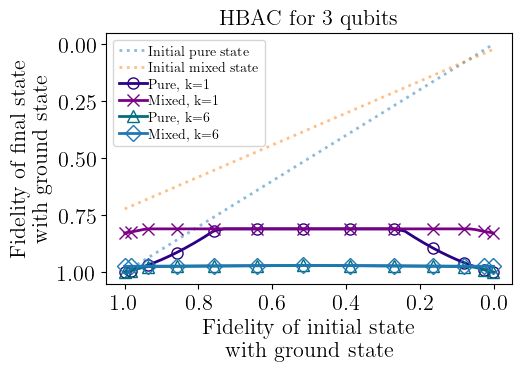

In [202]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5.5, 4))

ax.plot([fidelity_with_0(psi) for psi in psis],
        [fidelity_with_0(psi) for psi in psis],
        label=r"Initial pure state", alpha=0.5, linestyle=':')

ax.plot([fidelity_with_0(psi) for psi in psis],
        [fidelity_with_0(psi) for psi in mixed_state],
        label=r"Initial mixed state", alpha=0.5, linestyle=':')

color = ['#2c0084', '#7a0085', '#006f7a', 'C0']
markers = ['o', 'x', '^', 'D']

ax.plot([fidelity_with_0(psi) for psi in psis], hbac_fid_pure,
        label='Pure, k=1',
        color=color[0], marker=markers[0], markevery=4, markerfacecolor='None')

ax.plot([fidelity_with_0(psi) for psi in psis], hbac_fid_mixed,
        label='Mixed, k=1',
        color=color[1], marker=markers[1], markevery=4, markerfacecolor='None')

ax.plot([fidelity_with_0(psi) for psi in psis], hbac_fid_pure_2,
        label='Pure, k=6',
        color=color[2], marker=markers[2], markevery=4, markerfacecolor='None')

ax.plot([fidelity_with_0(psi) for psi in psis], hbac_fid_mixed_2,
        label='Mixed, k=6',
        color=color[3], marker=markers[3], markevery=4, markerfacecolor='None')

ax.set_xlabel('Fidelity of initial state\nwith ground state')
ax.set_ylabel('Fidelity of final state\nwith ground state')
ax.legend(fontsize=10)
plt.title('HBAC for 3 qubits')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
